# Trend Factor Analysis

This notebook walks through a trend factor analysis, for both time series and cross-sectional strategies, in digital assets.

We will construct various trend factors and compare their performance across a range of statistical tests and financial evaluation criteria.

Trend following is a ubiquitous factor investing strategy and remains one of the best ways to capture convexity in cryptoassets.

To conduct this analysis, we will use **FactorLab**, an open-source python package we have created specifically for alpha and risk factor analysis. 

To install **FactorLab**:
`pip install factorlab`

In [1]:
# uncomment to install factorlab
# pip install factorlab

In [2]:
import pandas as pd
import numpy as np

# from cryptodatapy.extract.datarequest import DataRequest
# from cryptodatapy.extract.getdata import GetData
# from cryptodatapy.transform.clean import CleanData

from factorlab.feature_engineering.factors.trend import Trend
from factorlab.feature_engineering.transform import Transform
from factorlab.feature_analysis.factor_analysis import Factor
from factorlab.feature_analysis.param_grid_search import *
from factorlab.feature_analysis.time_series_analysis import linear_reg, rolling_window
from factorlab.feature_analysis.performance import Performance
from factorlab.data_viz.data_viz import plot_series, plot_bar, plot_table

## Data 

To collect the necessary data for this analysis (perpetual futures, funding rates, spot prices, and aggregate spot prices), we use **CryptoDataPy**, an open source python library that makes it easy to build high quality data pipelines for the analysis of cryptoassets.

With it, we can pull data from various exchanges and data vendors with ease, clean and stich it to create the longest possible price and total return series.

To install **CryptoDataPy**:
`pip install cryptodatapy`

In [3]:
# uncomment to install cryptodatapy
# pip install cryptodatapy

### Collect Data

- Funding rates and perptual futures OHLC prices from **Binance** futures exchange (2019-present)
- OHLC spot prices from **Binance** spot exchange (2017-2019)
- OHLC spot prices from **Cryptocompare** (2010-2017)

### Tickers

#### Binance

In [4]:
# # get all Binance perp futures tickers
# data_req = DataRequest(source='ccxt')
# perp_tickers = GetData(data_req).get_meta(method='get_markets_info', exch='binanceusdm', as_list=True)

In [5]:
# # get Binance spot tickers
# data_req = DataRequest(source='ccxt')
# spot_tickers = GetData(data_req).get_meta(method='get_markets_info', exch='binance', as_list=True)

In [6]:
# # find intersecting tickers
# binance_tickers = [ticker for ticker in perp_tickers if ticker in spot_tickers]

In [7]:
# # number of tickers
# len(binance_tickers)

#### Cryptocompare 

In [8]:
# # get cryptocompare tickers
# data_req = DataRequest(source='cryptocompare')
# cc_tickers = GetData(data_req).get_meta(method='get_assets_info', as_list=True)

In [9]:
# # keep only USDT ticker
# bin_tickers = []
# for ticker in binance_tickers:
#     if '/' in ticker and ticker.split('/')[1] == 'USDT':
#         bin_tickers.append(ticker.split('/')[0])

In [10]:
# # usdt tickers
# usdt_tickers = [ticker.split('/')[0] for ticker in binance_tickers if '/'in ticker and ticker.split('/')[1] == 'USDT']

In [11]:
# # intersecting tickers
# tickers = [ticker for ticker in usdt_tickers if ticker in cc_tickers]

### OHLC Prices

#### Binance - Perpetual Futures

In [12]:
# # pull daily OHLC and funding rates for perp futures on Binance USDM exchange
# data_req = DataRequest(source='ccxt',
#                        tickers=tickers, 
#                        fields=['open', 'high', 'low', 'close', 'volume', 'funding_rate'], 
#                        mkt_type='perpetual_future', 
#                        freq='d')

In [13]:
# df1 = GetData(data_req).get_series()

In [14]:
# df1.head()

In [15]:
# pull csv perp futures prices
df1 = pd.read_csv('../src/factorlab/datasets/data/binance_perp_fut_prices.csv', 
                  index_col=['date', 'ticker'],
                  parse_dates=True
                 )

#### Binance - Spot Prices

In [16]:
# # pull OHLC from Binance
# data_req = DataRequest(source='ccxt',
#                        tickers=tickers, 
#                        fields=['open', 'high', 'low', 'close', 'volume'], 
#                        freq='d')

In [17]:
# df2 = GetData(data_req).get_series()

In [18]:
# df2.head()

In [19]:
# pull csv spot prices, binance
df2 = pd.read_csv('../src/factorlab/datasets/data/binance_spot_prices.csv', 
                  index_col=['date', 'ticker'],
                  parse_dates=True
                 )

#### CryptoCompare - Historical Spot

In [20]:
# # pull close and funding rates for agg spot data from CryptoCompare
# data_req = DataRequest(source='cryptocompare',
#                        tickers=tickers, 
#                        fields=['open', 'high', 'low', 'close', 'volume'], 
#                        freq='d')

In [21]:
# df3 = GetData(data_req).get_series()

In [22]:
# df3.head()

In [23]:
# pull csv spot prices, cryptocompare
df3 = pd.read_csv('../src/factorlab/datasets/data/cc_spot_prices.csv', 
                  index_col=['date', 'ticker'],
                  parse_dates=True
                 )

###  Preprocess Data

#### Stich perp futures, spot and historical spot OHLC prices

In [24]:
# stich dfs to extend price time series
df = df1.combine_first(df2).combine_first(df3)
df = df[['open', 'high', 'low', 'close', 'volume', 'funding_rate']]
df.funding_rate = df.funding_rate.fillna(0)

#### Clean data

Now, that we have all of our raw data, we can clean our data using the *CleanData* class in **CryptoDataPy** and chaining the following methods:

- *Filter outliers* to remove outliers using interquantile range and a threshold.
- *Repair outliers* and missing values using the IQR expected value.
- *Filter average trading value* to reduce the trading universe to include only asset trading a minimum of daily dollar volume (1 mil USD).
- *Remove missing values gaps* to drop the values of any series where sequential missing values are above some threshodl value.

In [25]:
# drop tickers with nobs < ts_obs
obs = df.groupby(level=1).count().min(axis=1)
drop_tickers_list = obs[obs < 365].index.to_list()
df = df.drop(drop_tickers_list, level=1, axis=0)

# drop tickers with nobs < cs_obs
obs = df.groupby(level=0).count().min(axis=1)
idx_start = obs[obs > 3].index[0]
df = df.unstack()[df.unstack().index > idx_start].stack()

In [26]:
# number of assets
len(list(df.index.droplevel(0).unique()))

209

## Target and Factor Construction

In [27]:
# create ohlc df
ohlc = df[['open', 'high', 'low', 'close']].copy()

### Create Targets
Create log return and forward return target variables.

In [28]:
# compute total returns
ret_df = Transform(df.close).returns()
ret_df = pd.concat([ret_df, df.funding_rate], axis=1).dropna()
ret_df['tr'] = ret_df.close.subtract(ret_df.funding_rate, axis=0)

In [29]:
# compute forward returns
fwd_spot_ret = Transform(df.close).returns(lags=1, forward=True).rename(columns={'close':'fwd_ret_1'})
fwd_spot_ret['fwd_ret_5'] = Transform(df.close).returns(lags=5, forward=True).close
fwd_spot_ret['fwd_ret_7'] = Transform(df.close).returns(lags=7, forward=True).close
fwd_spot_ret['fwd_ret_10'] = Transform(df.close).returns(lags=10, forward=True).close
fwd_spot_ret['fwd_ret_14'] = Transform(df.close).returns(lags=14, forward=True).close
fwd_spot_ret['fwd_ret_20'] = Transform(df.close).returns(lags=20, forward=True).close
fwd_spot_ret['fwd_ret_30'] = Transform(df.close).returns(lags=30, forward=True).close
fwd_spot_ret['fwd_ret_60'] = Transform(df.close).returns(lags=60, forward=True).close
fwd_spot_ret['fwd_ret_90'] = Transform(df.close).returns(lags=90, forward=True).close
fwd_spot_ret['fwd_ret_180'] = Transform(df.close).returns(lags=180, forward=True).close
fwd_spot_ret['fwd_ret_365'] = Transform(df.close).returns(lags=365, forward=True).close

In [30]:
# normalize fwd rets
fwd_ret_norm = Transform(fwd_spot_ret).normalize_ts(window_type='expanding')

In [31]:
# compute fwd relative returns
fwd_rel_ret = fwd_spot_ret.copy()
for col in fwd_rel_ret.columns:
    fwd_rel_ret[col] = fwd_spot_ret[col] - fwd_spot_ret[col].groupby('date').mean()

In [32]:
# mkt returns
mkt_ret = ret_df.close.unstack().mean(axis=1).to_frame('mkt_ret')

### Compute Trend Factors

- We compute a dozen trend factors across varying lookback windows which to compare performance.

In [34]:
# trend factors
# breakout
trend_df = Trend(ohlc, vwap=True, log=True, lookback=5).breakout()
trend_df['breakout_10'] = Trend(ohlc, vwap=True, log=True, lookback=10).breakout()
trend_df['breakout_15'] = Trend(ohlc, vwap=True, log=True, lookback=15).breakout()
trend_df['breakout_30'] = Trend(ohlc, vwap=True, log=True, lookback=30).breakout()
trend_df['breakout_45'] = Trend(ohlc, vwap=True, log=True, lookback=45).breakout()
trend_df['breakout_90'] = Trend(ohlc, vwap=True, log=True, lookback=90).breakout()
trend_df['breakout_180'] = Trend(ohlc, vwap=True, log=True, lookback=180).breakout()
trend_df['breakout_365'] = Trend(ohlc, vwap=True, log=True, lookback=365).breakout()
# price mom
trend_df['price_mom_5'] = Trend(ohlc, vwap=True, log=True, lookback=5).price_mom()
trend_df['price_mom_10'] = Trend(ohlc, vwap=True, log=True, lookback=10).price_mom()
trend_df['price_mom_15'] = Trend(ohlc, vwap=True, log=True, lookback=15).price_mom()
trend_df['price_mom_30'] = Trend(ohlc, vwap=True, log=True, lookback=30).price_mom()
trend_df['price_mom_45'] = Trend(ohlc, vwap=True, log=True, lookback=45).price_mom()
trend_df['price_mom_90'] = Trend(ohlc, vwap=True, log=True, lookback=90).price_mom()
trend_df['price_mom_180'] = Trend(ohlc, vwap=True, log=True, lookback=180).price_mom()
trend_df['price_mom_365'] = Trend(ohlc, vwap=True, log=True, lookback=365).price_mom()
# moving window diff
trend_df['mw_diff_5'] = Trend(ohlc, vwap=True, log=True, lookback=5, sm_window_type='ewm').mw_diff()
trend_df['mw_diff_10'] = Trend(ohlc, vwap=True, log=True, lookback=10, sm_window_type='ewm').mw_diff()
trend_df['mw_diff_15'] = Trend(ohlc, vwap=True, log=True, lookback=15, sm_window_type='ewm').mw_diff()
trend_df['mw_diff_30'] = Trend(ohlc, vwap=True, log=True, lookback=30, sm_window_type='ewm').mw_diff()
trend_df['mw_diff_45'] = Trend(ohlc, vwap=True, log=True, lookback=45, sm_window_type='ewm').mw_diff()
trend_df['mw_diff_90'] = Trend(ohlc, vwap=True, log=True, lookback=90, sm_window_type='ewm').mw_diff()
trend_df['mw_diff_180'] = Trend(ohlc, vwap=True, log=True, lookback=180, sm_window_type='ewm').mw_diff()
trend_df['mw_diff_365'] = Trend(ohlc, vwap=True, log=True, lookback=365, sm_window_type='ewm').mw_diff()
# divergence
trend_df['divergence_5'] = Trend(ohlc, vwap=True, log=True, lookback=5, sm_window_type='ewm').divergence()
trend_df['divergence_10'] = Trend(ohlc, vwap=True, log=True, lookback=10, sm_window_type='ewm').divergence()
trend_df['divergence_15'] = Trend(ohlc, vwap=True, log=True, lookback=15, sm_window_type='ewm').divergence()
trend_df['divergence_30'] = Trend(ohlc, vwap=True, log=True, lookback=30, sm_window_type='ewm').divergence()
trend_df['divergence_45'] = Trend(ohlc, vwap=True, log=True, lookback=45, sm_window_type='ewm').divergence()
trend_df['divergence_90'] = Trend(ohlc, vwap=True, log=True, lookback=90, sm_window_type='ewm').divergence()
trend_df['divergence_180'] = Trend(ohlc, vwap=True, log=True, lookback=180, sm_window_type='ewm').divergence()
trend_df['divergence_365'] = Trend(ohlc, vwap=True, log=True, lookback=365, sm_window_type='ewm').divergence()
# exp weighted mov avg crossover
trend_df['ewma_xover_2'] = Trend(ohlc, vwap=True, log=True,).ewma_wxover(s_k=[2, 4, 8], l_k=[6, 12, 24], signal=True)
trend_df['ewma_xover_3'] = Trend(ohlc, vwap=True, log=True,).ewma_wxover(s_k=[3, 6, 12], l_k=[9, 18, 36], signal=True)
trend_df['ewma_xover_4'] = Trend(ohlc, vwap=True, log=True,).ewma_wxover(s_k=[4, 8, 16], l_k=[12, 24, 48], signal=True)
trend_df['ewma_xover_5'] = Trend(ohlc, vwap=True, log=True,).ewma_wxover(s_k=[5, 10, 20], l_k=[15, 30, 60], signal=True)
trend_df['ewma_xover_6'] = Trend(ohlc, vwap=True, log=True,).ewma_wxover(s_k=[6, 12, 24], l_k=[18, 36, 72], signal=True)
trend_df['ewma_xover_7'] = Trend(ohlc, vwap=True, log=True,).ewma_wxover(s_k=[7, 14, 28], l_k=[21, 42, 84], signal=True)
trend_df['ewma_xover_ahl'] = Trend(ohlc, vwap=True, log=True,).ewma_wxover(s_k=[8, 16, 32], l_k=[24, 48, 96], signal=True)
# rsi
trend_df['rsi_5'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=5).rsi()
trend_df['rsi_10'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=10).rsi()
trend_df['rsi_15'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=15).rsi()
trend_df['rsi_30'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=30).rsi()
trend_df['rsi_45'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=45).rsi()
trend_df['rsi_90'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=90).rsi()
trend_df['rsi_180'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=180).rsi()
trend_df['rsi_365'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=365).rsi()
# stochastic
trend_df['stoch_5'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=5).stochastic()
trend_df['stoch_10'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=10).stochastic()
trend_df['stoch_15'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=15).stochastic()
trend_df['stoch_30'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=30).stochastic()
trend_df['stoch_45'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=45).stochastic()
trend_df['stoch_90'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=90).stochastic()
trend_df['stoch_180'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=180).stochastic()
trend_df['stoch_365'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=365).stochastic()
# intensity
trend_df['intensity_5'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=5).intensity()
trend_df['intensity_10'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=10).intensity()
trend_df['intensity_15'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=15).intensity()
trend_df['intensity_30'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=30).intensity()
trend_df['intensity_45'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=45).intensity()
trend_df['intensity_90'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=90).intensity()
trend_df['intensity_180'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=180).intensity()
trend_df['intensity_365'] = Trend(ohlc, vwap=True, log=True, sm_window_type='ewm', lookback=365).intensity()
# time trend
trend_df['time_trend_5'] = Trend(ohlc, vwap=True, log=True, lookback=5).time_trend()
trend_df['time_trend_10'] = Trend(ohlc, vwap=True, log=True, lookback=10).time_trend()
trend_df['time_trend_15'] = Trend(ohlc, vwap=True, log=True, lookback=15).time_trend()
trend_df['time_trend_30'] = Trend(ohlc, vwap=True, log=True, lookback=30).time_trend()
trend_df['time_trend_45'] = Trend(ohlc, vwap=True, log=True, lookback=45).time_trend()
trend_df['time_trend_90'] = Trend(ohlc, vwap=True, log=True, lookback=90).time_trend()
trend_df['time_trend_180'] = Trend(ohlc, vwap=True, log=True, lookback=180).time_trend()
trend_df['time_trend_365'] = Trend(ohlc, vwap=True, log=True, lookback=365).time_trend()
# alpha mom
trend_df['alpha_mom_5'] = Trend(ohlc, vwap=True, log=True, lookback=5).alpha_mom()
trend_df['alpha_mom_10'] = Trend(ohlc, vwap=True, log=True, lookback=10).alpha_mom()
trend_df['alpha_mom_15'] = Trend(ohlc, vwap=True, log=True, lookback=15).alpha_mom()
trend_df['alpha_mom_30'] = Trend(ohlc, vwap=True, log=True, lookback=30).alpha_mom()
trend_df['alpha_mom_45'] = Trend(ohlc, vwap=True, log=True, lookback=45).alpha_mom()
trend_df['alpha_mom_90'] = Trend(ohlc, vwap=True, log=True, lookback=90).alpha_mom()
trend_df['alpha_mom_180'] = Trend(ohlc, vwap=True, log=True, lookback=180).alpha_mom()
trend_df['alpha_mom_365'] = Trend(ohlc, vwap=True, log=True, lookback=365).alpha_mom()
# energy
trend_df['energy_5'] = Trend(ohlc, vwap=True, log=True, lookback=5).energy()
trend_df['energy_10'] = Trend(ohlc, vwap=True, log=True, lookback=10).energy()
trend_df['energy_15'] = Trend(ohlc, vwap=True, log=True, lookback=15).energy()
trend_df['energy_30'] = Trend(ohlc, vwap=True, log=True, lookback=30).energy()
trend_df['energy_45'] = Trend(ohlc, vwap=True, log=True, lookback=45).energy()
trend_df['energy_90'] = Trend(ohlc, vwap=True, log=True, lookback=90).energy()
trend_df['energy_180'] = Trend(ohlc, vwap=True, log=True, lookback=180).energy()
trend_df['energy_365'] = Trend(ohlc, vwap=True, log=True, lookback=365).energy()

/Users/nickl/opt/anaconda3/envs/factorlab/lib/python3.9/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood
/Users/nickl/opt/anaconda3/envs/factorlab/lib/python3.9/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood
/Users/nickl/opt/anaconda3/envs/factorlab/lib/python3.9/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood
/Users/nickl/opt/anaconda3/envs/factorlab/lib/python3.9/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood
/Users/nickl/opt/anaconda3/envs/factorlab/lib/python3.9/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero 

/Users/nickl/opt/anaconda3/envs/factorlab/lib/python3.9/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood
/Users/nickl/opt/anaconda3/envs/factorlab/lib/python3.9/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood
/Users/nickl/opt/anaconda3/envs/factorlab/lib/python3.9/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood
/Users/nickl/opt/anaconda3/envs/factorlab/lib/python3.9/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood
/Users/nickl/opt/anaconda3/envs/factorlab/lib/python3.9/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero 

In [124]:
# normalize trend factors
trend_z_df = Transform(trend_df).normalize_ts(window_type='expanding')

In [125]:
trend_df.unstack().shape

(3639, 18183)

In [126]:
trend_df.columns

Index(['breakout_5', 'breakout_10', 'breakout_15', 'breakout_30',
       'breakout_45', 'breakout_90', 'breakout_180', 'breakout_365',
       'price_mom_5', 'price_mom_10', 'price_mom_15', 'price_mom_30',
       'price_mom_45', 'price_mom_90', 'price_mom_180', 'price_mom_365',
       'mw_diff_5', 'mw_diff_10', 'mw_diff_15', 'mw_diff_30', 'mw_diff_45',
       'mw_diff_90', 'mw_diff_180', 'mw_diff_365', 'divergence_5',
       'divergence_10', 'divergence_15', 'divergence_30', 'divergence_45',
       'divergence_90', 'divergence_180', 'divergence_365', 'ewma_xover_2',
       'ewma_xover_3', 'ewma_xover_4', 'ewma_xover_5', 'ewma_xover_6',
       'ewma_xover_7', 'ewma_xover_ahl', 'rsi_5', 'rsi_10', 'rsi_15', 'rsi_30',
       'rsi_45', 'rsi_90', 'rsi_180', 'rsi_365', 'stoch_5', 'stoch_10',
       'stoch_15', 'stoch_30', 'stoch_45', 'stoch_90', 'stoch_180',
       'stoch_365', 'intensity_5', 'intensity_10', 'intensity_15',
       'intensity_30', 'intensity_45', 'intensity_90', 'intensity_180'

# Factor Analysis

## Statistical Tests

Statistical tests allow us to assess the strenght of the relationship between the alpha factors (features) and foward returns (target variable).


### Historical Correlation and Association Measures
Correlation measures, e.g. spearman rank correlation (aka information coefficient), and association measures, e.g. mutul information, allow us to evaluate the predictive relationship between an alpha factors and forward returns. 
- The `strategy` parameter in the `filter` method can be set to either "ts" or "cs" for either time series or cross-sectional strategies.

In [142]:
# compute stats for time series strategies
Factor(trend_df, fwd_ret_norm.fwd_ret_7, strategy='ts', factor_bins=5, ret_bins=3, window_type='fixed').filter(rank_on='spearman_r')

,spearman_r
stoch_30,0.01
time_trend_30,0.01
price_mom_30,0.01
divergence_10,0.00
divergence_15,0.00
...,...
mw_diff_180,-0.09
breakout_365,-0.09
mw_diff_365,-0.10
rsi_180,-0.10


In [143]:
# compute stats for cross-sectional strategies 
Factor(trend_df, fwd_ret_norm.fwd_ret_7, strategy='cs', factor_bins=5, ret_bins=3, window_type='fixed').filter(rank_on='spearman_r')

,spearman_r
energy_365,-0.03
divergence_5,-0.04
breakout_5,-0.04
divergence_10,-0.04
divergence_15,-0.05
...,...
mw_diff_90,-0.10
rsi_45,-0.11
rsi_90,-0.13
rsi_180,-0.14


In [144]:
# compute stats for dual strategies 
Factor(trend_df, fwd_ret_norm.fwd_ret_7, strategy='dual', factor_bins=5, ret_bins=3, window_type='fixed').filter(rank_on='spearman_r')

,spearman_r
stoch_30,-0.01
divergence_5,-0.01
divergence_10,-0.01
divergence_15,-0.02
ewma_xover_2,-0.02
...,...
mw_diff_180,-0.09
mw_diff_365,-0.09
breakout_365,-0.09
rsi_180,-0.10


### Moving Window IC
The information coefficient (or spearman rank correlation) can be computed over a rolling window to allow us to see the change in predictive relationship between the factors and forward returns.


In [145]:
# IC rolling window for time series strategy
ic_ts_df = Factor(trend_df, ret_df.close, strategy='ts_ls', window_size=365).ic(factor='price_mom_30')

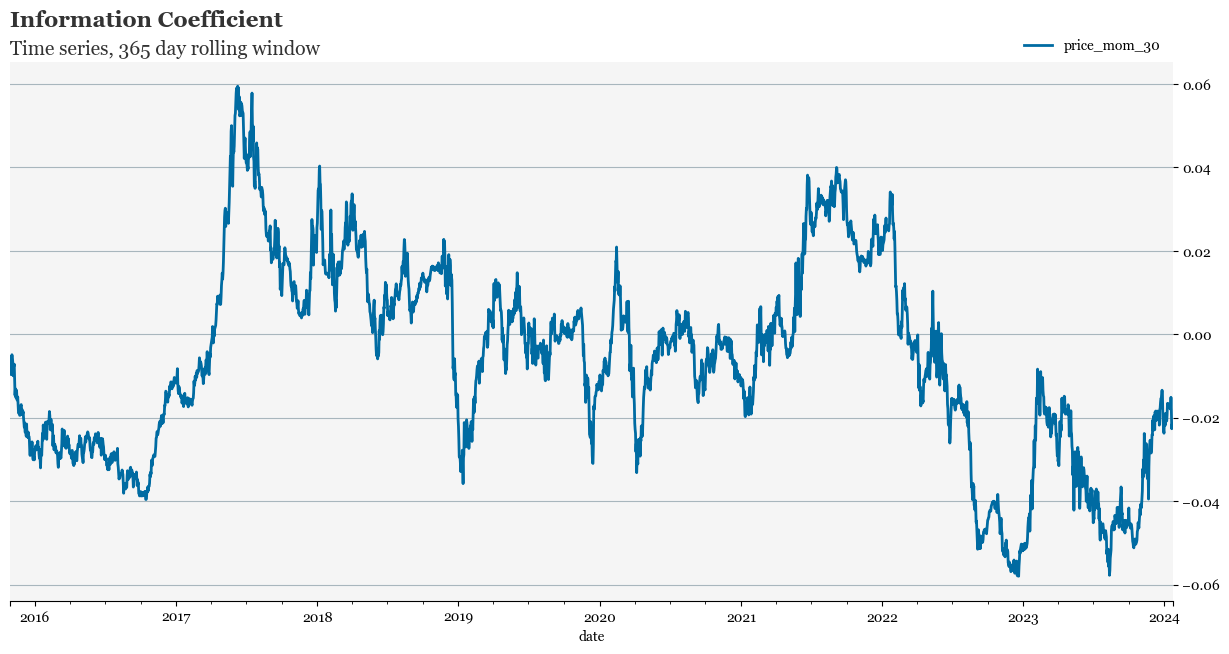

In [146]:
plot_series(ic_ts_df.dropna(), 
            title='Information Coefficient',
            subtitle='Time series, 365 day rolling window'
           )

In [147]:
# IC rolling window for cross sectional strategy
ic_cs_df = Factor(trend_df, ret_df.close, strategy='cs_ls', window_size=365).ic(factor='price_mom_30')

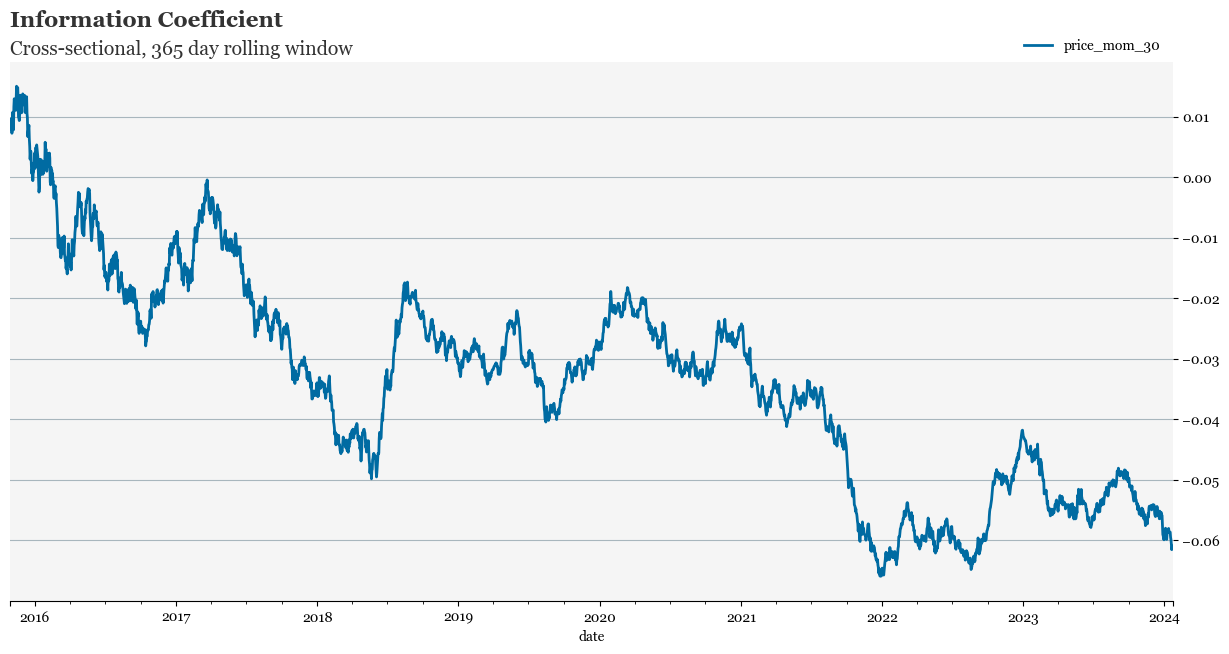

In [148]:
plot_series(ic_cs_df.dropna(), 
            title='Information Coefficient',
            subtitle='Cross-sectional, 365 day rolling window'
           )

In [149]:
# IC rolling window for cross sectional strategy
ic_dual_df = Factor(trend_df, ret_df.close, strategy='dual_ls', window_size=365).ic(factor='price_mom_30')

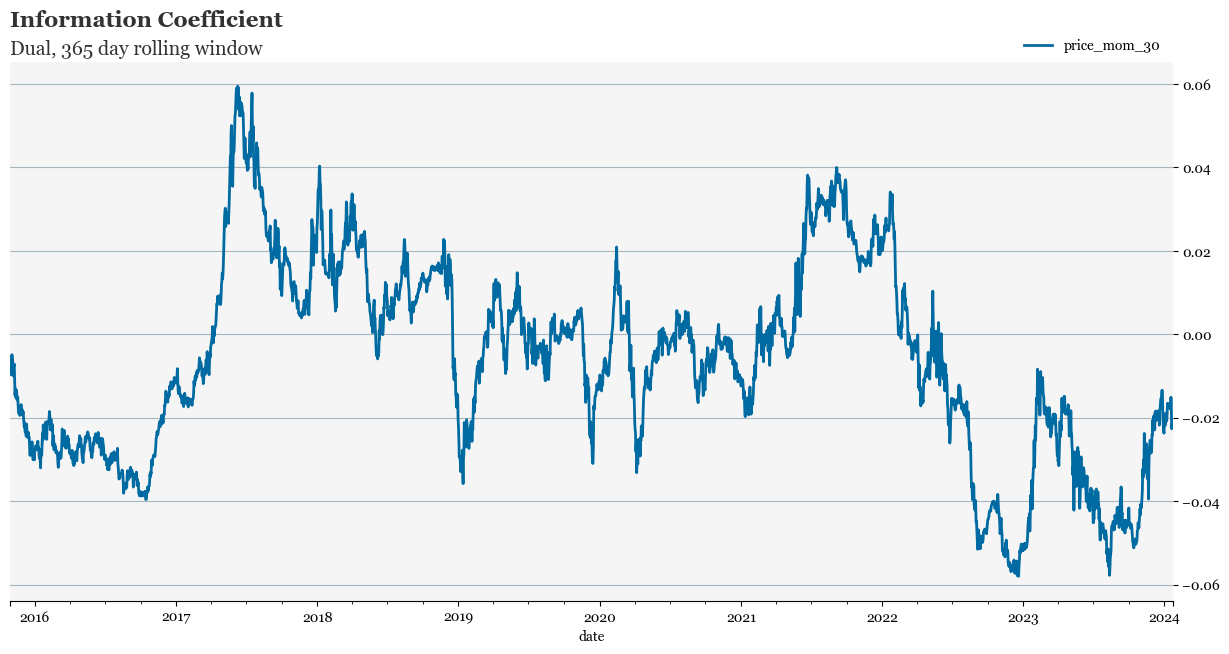

In [150]:
plot_series(ic_dual_df.dropna(), 
            title='Information Coefficient',
            subtitle='Dual, 365 day rolling window'
           )

### Regression
We can regress factors on forward returns (normalized) to assess their economic and statistical significance.


In [151]:
# pooled regression for time series 
Factor(trend_z_df, fwd_ret_norm.fwd_ret_7, strategy='ts').regression(method='pooled')

,beta,pval,rsq
stoch_30,0.070338,0.0,0.008307
time_trend_45,0.065392,0.0,0.005266
time_trend_30,0.063927,0.0,0.00467
stoch_45,0.063057,0.0,0.007077
divergence_45,0.062142,0.0,0.004975
...,...,...,...
energy_5,-0.007374,0.034704,0.000067
alpha_mom_5,-0.010734,0.001392,0.000096
energy_180,-0.011081,0.0,0.000354
mw_diff_180,-0.015825,0.0,0.000566


In [152]:
# cross sectional fama-macbeth
Factor(trend_z_df, fwd_ret_norm.fwd_ret_7, strategy='cs').regression(method='fama-macbeth')

,beta,std_error,t-stat
time_trend_30,0.0998,0.0070,14.2069
price_mom_15,0.0985,0.0085,11.5434
price_mom_30,0.0957,0.0082,11.6977
time_trend_15,0.0897,0.0076,11.8248
price_mom_10,0.0867,0.0087,10.0111
...,...,...,...
energy_90,-0.0158,0.0113,-1.3952
energy_45,-0.0196,0.0127,-1.5454
mw_diff_180,-0.0203,0.0048,-4.2243
mw_diff_365,-0.0249,0.0041,-6.1523


## Factor Returns
Factor returns (net of t-cost estimate) provide a measure of factor performance. 
- The `strategy` parameter in the factor returns function allows you to explore factor returns for both long-only '_l' and long/short strategies '_ls', for either time series 'ts' or cross-sectional 'cs' implementations. 
- The `tails` parameter allows you to keep only factor values in the tails of the distribution and ignore the rest. Often, the most predictive information is contained in the tails.

### Time Series

In [153]:
# ts trend returns
trend_ts_ret = Factor(trend_df.loc['2016-01-01':], ret_df.tr, strategy='ts_ls', factor_bins=3).returns(signal_type='signal')

In [154]:
trend_ts_perf_table = Performance(trend_ts_ret, mkt_ret=mkt_ret, ret_type='log').table(metrics='all', rank_on='Sharpe ratio').iloc[:20]

In [155]:
trend_ts_perf_table.index.name = 'factor'
trend_ts_perf_table

,Cumulative return,Annual return,Annual volatility,Skewness,Kurtosis,Max drawdown,VaR,Tail ratio,Sharpe ratio,Sortino ratio,Calmar ratio,Omega ratio,Stability,Annual alpha,Alpha p-val,Beta,Beta p-val
factor,,,,,,,,,,,,,,,,,
stoch_45,62.62,0.67,0.52,-0.21,9.17,-0.46,-0.04,1.15,0.99,1.22,1.48,1.18,0.89,0.69,0.00,-0.03,0.00
stoch_30,59.49,0.66,0.53,0.27,11.38,-0.45,-0.04,1.12,0.97,1.24,1.48,1.18,0.90,0.69,0.00,-0.05,0.00
time_trend_45,32.60,0.55,0.50,0.56,22.84,-0.50,-0.03,1.15,0.88,1.09,1.09,1.18,0.84,0.54,0.01,0.01,0.22
divergence_45,24.02,0.49,0.46,0.95,15.63,-0.52,-0.03,1.11,0.86,1.15,0.94,1.17,0.84,0.49,0.01,-0.00,0.72
divergence_90,18.96,0.45,0.44,0.39,13.73,-0.47,-0.03,1.09,0.85,1.08,0.95,1.16,0.83,0.43,0.02,0.04,0.00
time_trend_30,21.51,0.47,0.49,0.29,18.56,-0.52,-0.03,1.09,0.80,0.96,0.91,1.16,0.74,0.50,0.02,-0.05,0.00
divergence_30,19.71,0.46,0.48,1.00,16.08,-0.57,-0.03,1.14,0.79,1.06,0.79,1.15,0.84,0.47,0.02,-0.03,0.00
divergence_180,10.38,0.35,0.41,-0.07,14.96,-0.53,-0.03,1.06,0.73,0.90,0.66,1.14,0.84,0.32,0.05,0.07,0.00
intensity_90,7.75,0.31,0.45,0.78,43.95,-0.50,-0.03,1.09,0.60,0.75,0.62,1.12,0.71,0.26,0.13,0.09,0.00


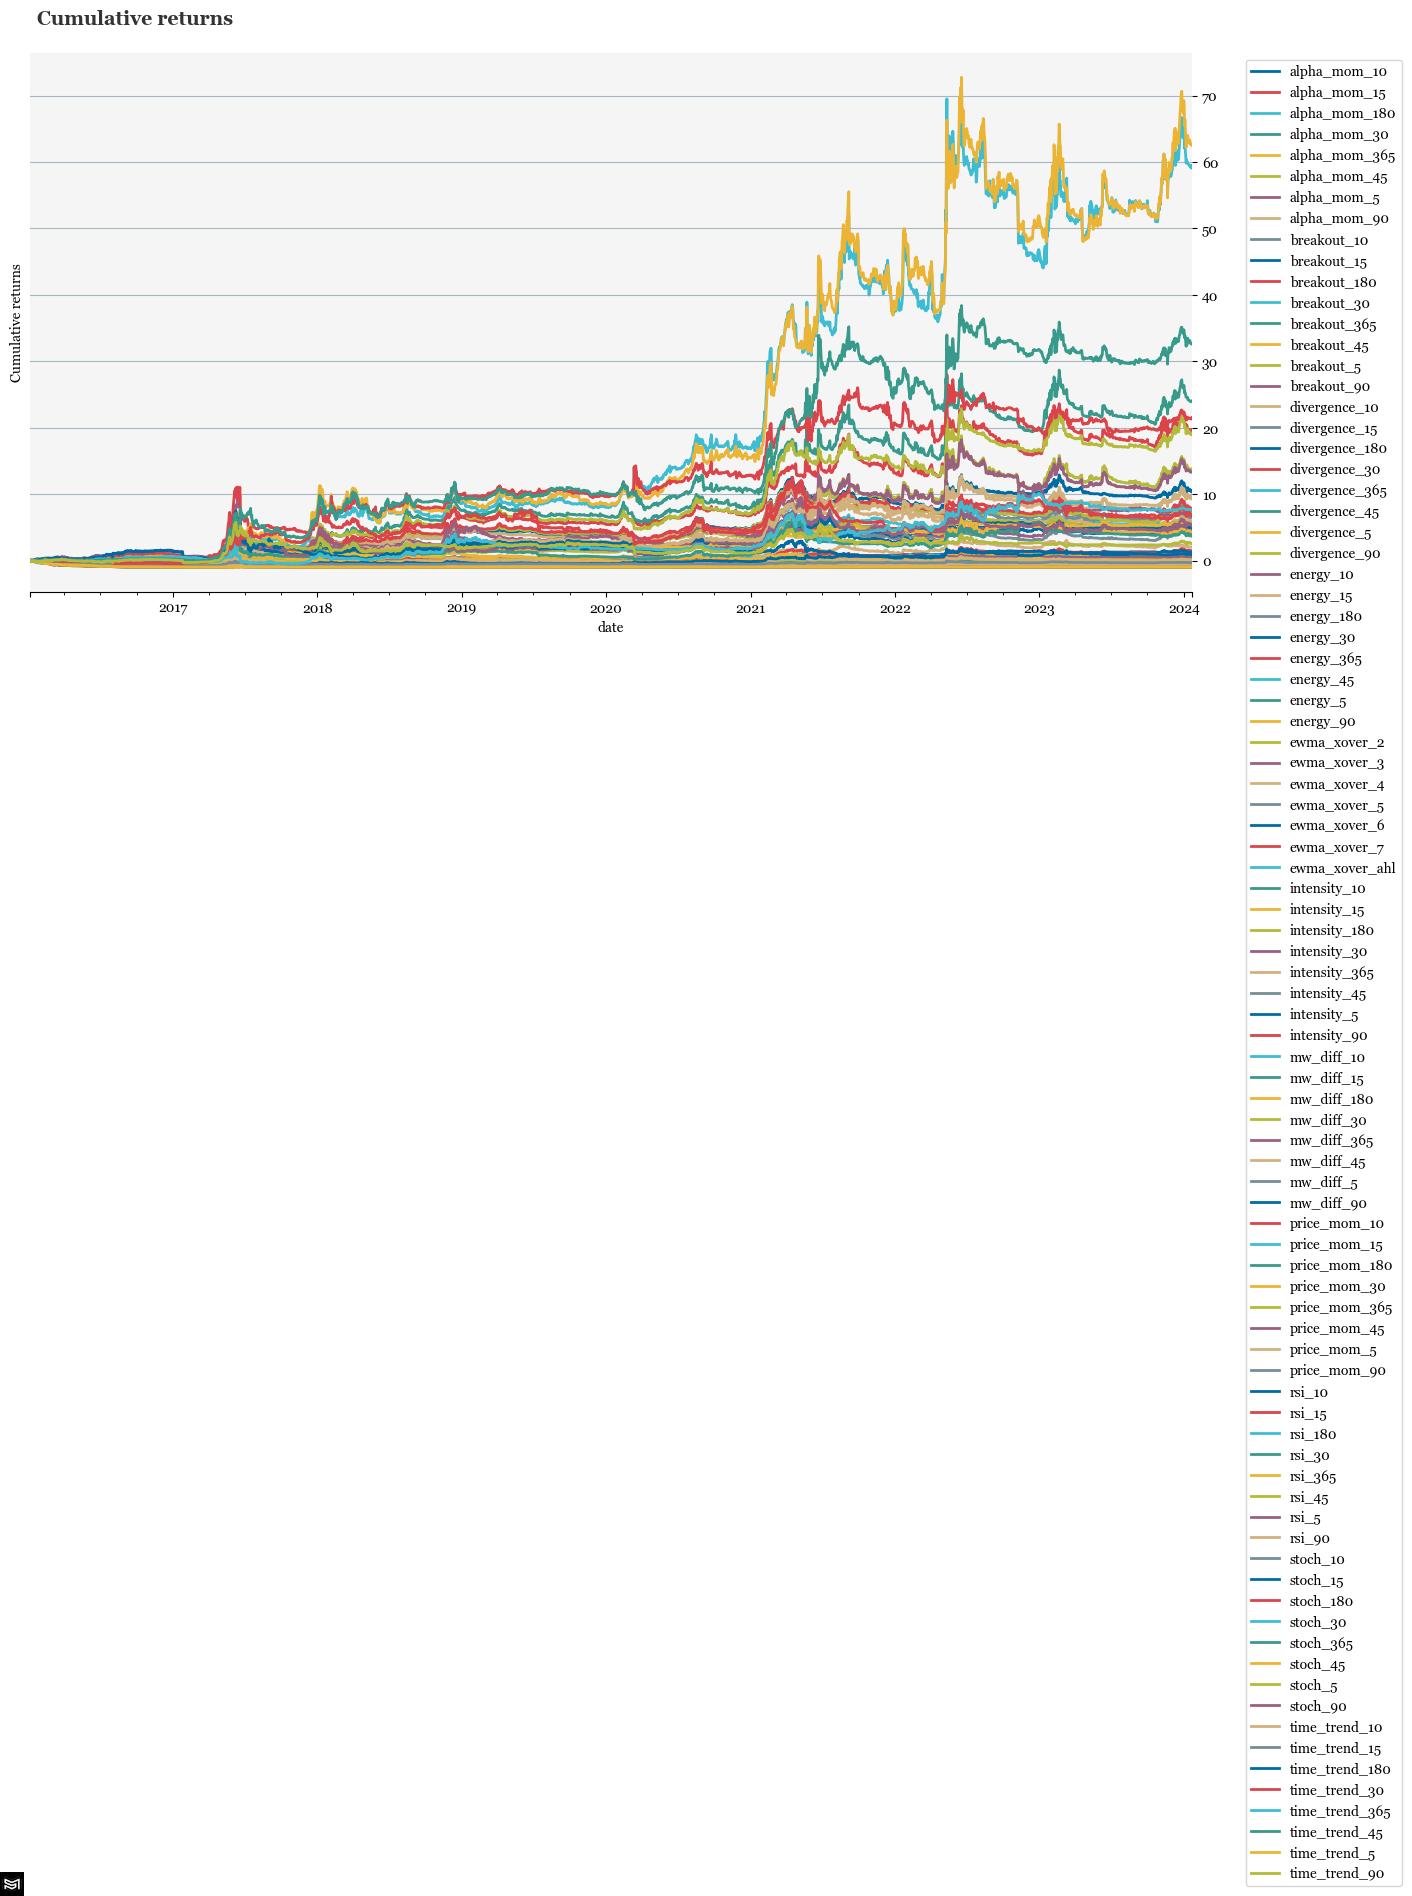

In [156]:
Performance(trend_ts_ret, mkt_ret=mkt_ret, ret_type='log', window_type='expanding').plot_metric()

In [157]:
trend_ts_perf_table.mean()

Cumulative return    17.2520
Annual return         0.3895
Annual volatility     0.4850
Skewness              1.1990
Kurtosis             37.7635
Max drawdown         -0.6025
VaR                  -0.0335
Tail ratio            1.0810
Sharpe ratio          0.6715
Sortino ratio         0.8635
Calmar ratio          0.6945
Omega ratio           1.1300
Stability             0.8055
Annual alpha          0.3825
Alpha p-val           0.0875
Beta                  0.0140
Beta p-val            0.0990
dtype: float64

### Cross-Sectional
Cross-sectional strategies sorts assets in the cross-section into equal-weighted portfolios based on their factor values. Weights for each portfolio can be scaled by on the portfolios quantile (e.g. 1 for the assets in the top quintile of factor values, 0.5 for the 2nd quintile, 0 for the third, etc), or traditional portfolio sorts where top vs. bottom quantiles are given weights of 1 and -1.

In [158]:
# cs trend returns
trend_cs_ret = Factor(trend_df.loc['2016-01-01':], ret_df.tr, strategy='cs_ls', factor_bins=5).returns(signal_type='signal_quantiles', tails='two', rebal_freq=7, t_cost=0.0025, weighting='ew')

In [159]:
trend_cs_perf_table = Performance(trend_cs_ret, mkt_ret=mkt_ret, ret_type='log').table(metrics='all', rank_on='Sharpe ratio')

In [160]:
trend_cs_perf_table

,Cumulative return,Annual return,Annual volatility,Skewness,Kurtosis,Max drawdown,VaR,Tail ratio,Sharpe ratio,Sortino ratio,Calmar ratio,Omega ratio,Stability,Annual alpha,Alpha p-val,Beta,Beta p-val
intensity_180,1.45,0.12,0.32,-0.01,76.51,-0.52,-0.02,1.09,0.35,0.40,0.23,1.09,0.29,0.15,0.20,-0.07,0.00
intensity_365,1.49,0.12,0.34,4.33,171.06,-0.59,-0.01,1.07,0.33,0.40,0.20,1.09,0.32,0.16,0.21,-0.09,0.00
intensity_90,0.95,0.09,0.29,0.47,67.69,-0.32,-0.02,1.04,0.28,0.34,0.27,1.06,0.12,0.10,0.35,-0.04,0.00
divergence_180,1.10,0.10,0.33,-1.13,88.76,-0.40,-0.02,1.05,0.28,0.30,0.24,1.07,0.00,0.11,0.36,-0.04,0.00
divergence_365,0.89,0.08,0.33,-1.56,88.96,-0.43,-0.02,1.08,0.24,0.24,0.19,1.06,0.03,0.11,0.39,-0.06,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
price_mom_180,-0.94,-0.29,0.41,-12.65,327.65,-0.97,-0.02,0.85,-0.83,-0.72,-0.30,0.80,0.82,-0.29,0.02,-0.00,0.69
price_mom_90,-0.94,-0.29,0.40,-11.67,283.49,-0.96,-0.02,0.92,-0.87,-0.76,-0.30,0.80,0.83,-0.29,0.02,-0.03,0.00
energy_90,-0.88,-0.23,0.30,-10.84,342.22,-0.90,-0.02,0.80,-0.87,-0.82,-0.26,0.82,0.83,-0.24,0.01,0.02,0.00
energy_30,-0.91,-0.26,0.34,-3.39,339.05,-0.93,-0.02,0.83,-0.87,-0.89,-0.28,0.80,0.84,-0.24,0.02,-0.06,0.00


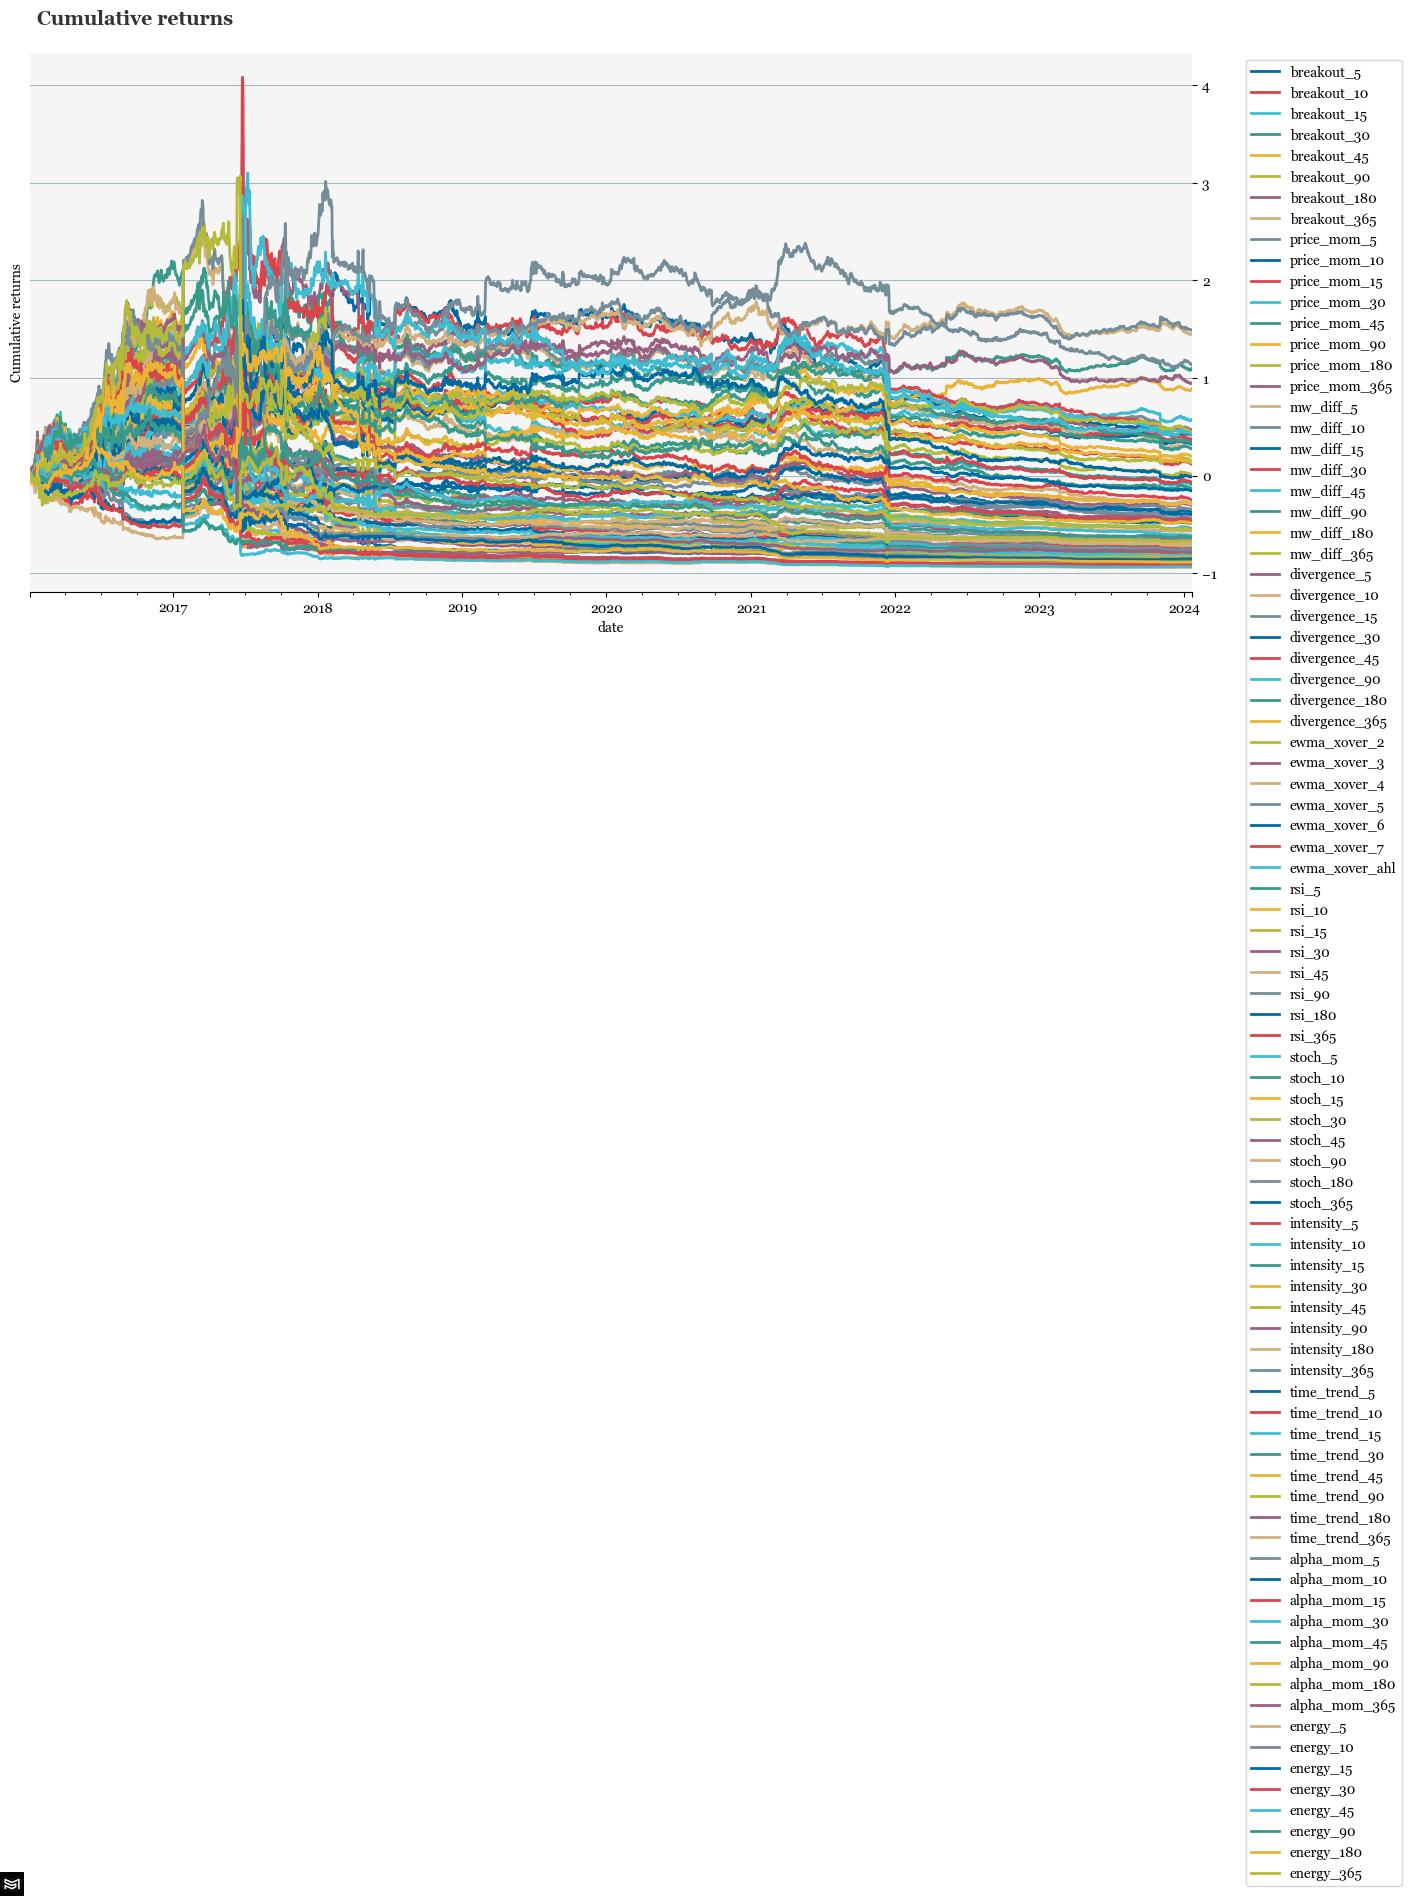

In [161]:
Performance(trend_cs_ret, mkt_ret=mkt_ret, ret_type='log', window_type='expanding').plot_metric()

In [162]:
trend_cs_perf_table.mean()

Cumulative return     -0.299770
Annual return         -0.084368
Annual volatility      0.366322
Skewness              -4.592529
Kurtosis             201.889885
Max drawdown          -0.733678
VaR                   -0.019770
Tail ratio             0.982184
Sharpe ratio          -0.248046
Sortino ratio         -0.233448
Calmar ratio          -0.086207
Omega ratio            0.941034
Stability              0.560345
Annual alpha          -0.085862
Alpha p-val            0.429080
Beta                   0.003218
Beta p-val             0.058506
dtype: float64

### Dual Strategies
Dual strategies (e.g. dual momentum) go long/short assets with factors that are high/low in both the cross section (relative to other assets) and in the time series (relative to the asset's own history). Dual strategies can enhance risk-adjusted returns by combining both time series and cross sectional strategies.

In [163]:
# dual trend returns
trend_dual_ret = Factor(trend_df.loc['2016-01-01':], ret_df.tr, strategy='dual_ls', factor_bins=3).returns(signal_type='signal_quantiles', rebal_freq=7, t_cost=0.0025, weighting='ew')

In [164]:
trend_dual_perf_table = Performance(trend_dual_ret, mkt_ret=mkt_ret, ret_type='log').table(metrics='all', rank_on='Sharpe ratio')

In [165]:
trend_dual_perf_table

,Cumulative return,Annual return,Annual volatility,Skewness,Kurtosis,Max drawdown,VaR,Tail ratio,Sharpe ratio,Sortino ratio,Calmar ratio,Omega ratio,Stability,Annual alpha,Alpha p-val,Beta,Beta p-val
stoch_30,28.03,0.52,0.39,1.43,39.81,-0.37,-0.03,1.13,1.06,1.39,1.39,1.20,0.76,0.51,0.00,0.01,0.04
stoch_45,17.08,0.43,0.37,-0.25,13.71,-0.38,-0.03,1.08,0.97,1.23,1.15,1.18,0.74,0.43,0.01,-0.00,0.62
intensity_180,11.41,0.37,0.33,-0.41,11.57,-0.41,-0.03,1.07,0.95,1.16,0.89,1.18,0.71,0.33,0.01,0.08,0.00
intensity_365,8.57,0.32,0.31,-0.59,11.17,-0.42,-0.02,1.15,0.92,1.10,0.77,1.17,0.73,0.28,0.02,0.08,0.00
divergence_365,9.45,0.34,0.33,-0.65,13.35,-0.40,-0.02,1.20,0.88,1.04,0.85,1.16,0.83,0.31,0.02,0.05,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
price_mom_180,-0.30,-0.04,0.44,-6.27,165.13,-0.90,-0.03,0.98,-0.10,-0.10,-0.05,0.98,0.55,-0.04,0.77,-0.00,0.94
alpha_mom_90,-0.29,-0.04,0.37,7.49,283.93,-0.79,-0.02,1.02,-0.12,-0.15,-0.05,0.97,0.65,-0.06,0.63,0.05,0.00
energy_180,-0.38,-0.06,0.31,-0.13,17.73,-0.77,-0.02,1.02,-0.19,-0.24,-0.08,0.97,0.71,-0.06,0.61,-0.01,0.22
alpha_mom_365,-0.45,-0.07,0.34,-4.55,93.66,-0.69,-0.02,1.10,-0.22,-0.22,-0.11,0.95,0.27,-0.08,0.48,0.02,0.00


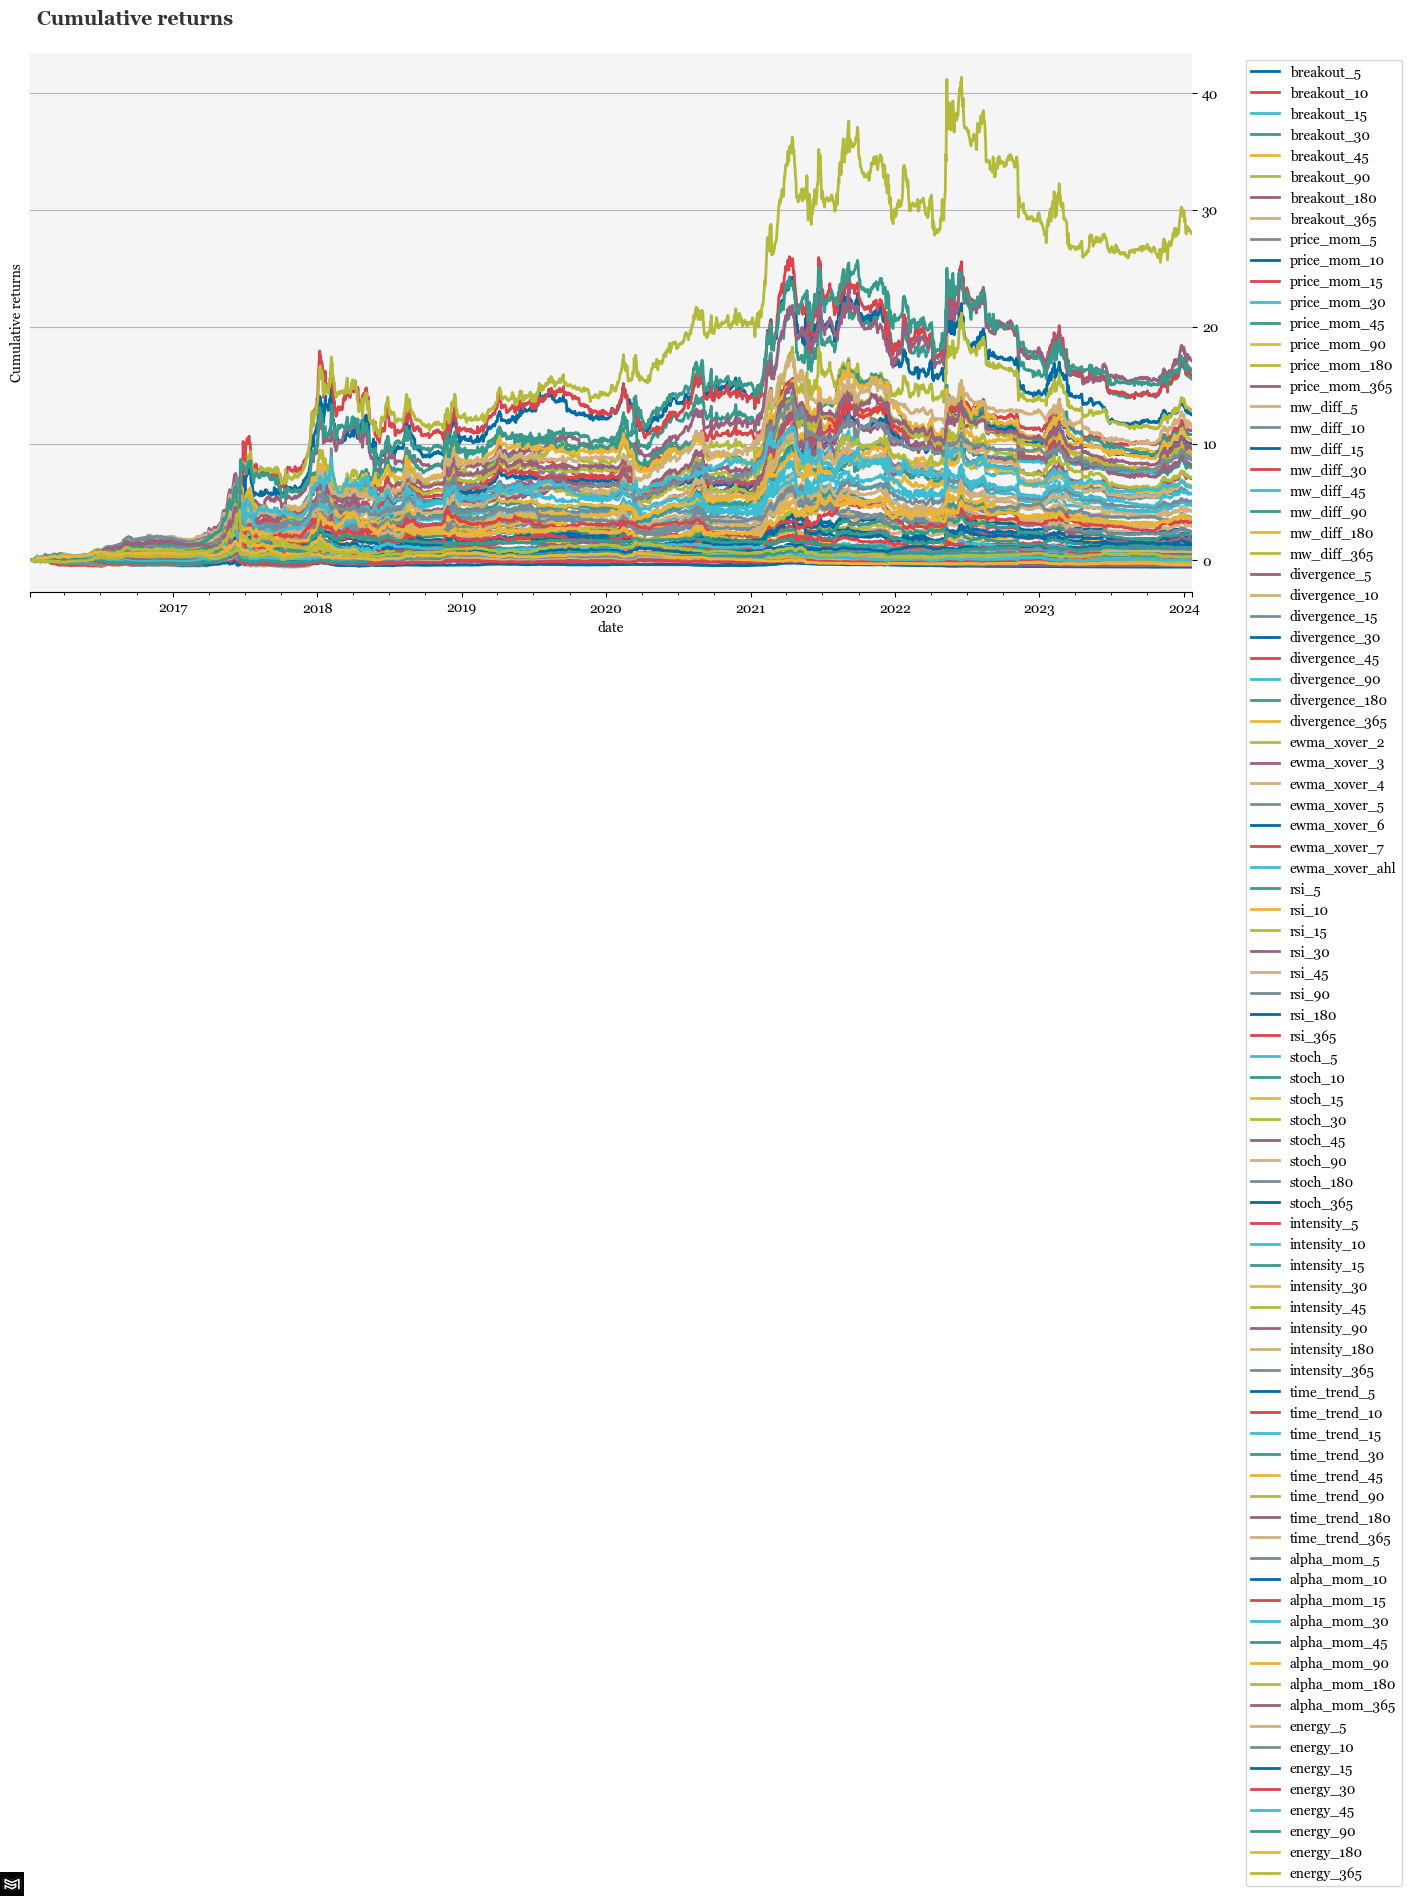

In [166]:
Performance(trend_dual_ret, mkt_ret=mkt_ret, ret_type='log', window_type='expanding').plot_metric()

In [167]:
trend_dual_perf_table.mean()

Cumulative return     4.419425
Annual return         0.174828
Annual volatility     0.395517
Skewness             -0.721034
Kurtosis             71.039195
Max drawdown         -0.537471
VaR                  -0.027586
Tail ratio            1.070575
Sharpe ratio          0.389425
Sortino ratio         0.492299
Calmar ratio          0.387356
Omega ratio           1.071724
Stability             0.521839
Annual alpha          0.163793
Alpha p-val           0.369770
Beta                  0.022069
Beta p-val            0.121609
dtype: float64

## Quantile Returns
Factor quantile returns provide a measure of alpha factor performance. 

We can use the ```quantiles``` method to analyze returns across bins/quantiles in order to assess the robustness of the alpha factor. Returns which increase monotonically with quantiles are likely to be more reliable that those with positive but non-monotonic relationships.

- The `factor` parameter in the quantile method allows us to select the factor for which to create quantiles. 
- The `metric` parameter allows us to compute a specific metrics from the ```Performance``` class. Here we use the default 'ret' value for returns.
- The ```rebal_freq``` parameter allows us to modify the rebalancing frequency for the strategy. This value defaults to 1, meaning changing with each period/frequency. We select '7' for weekly rebalancing with daily data frequency.

### Time Series Strategy

In [168]:
trend_ts_quantile_ret = Factor(trend_df.loc['2016-01-01':], ret_df.tr, strategy='ts_ls', factor_bins=3).quantiles(factor=trend_ts_perf_table.iloc[0].name, metric='ret', rebal_freq=7)

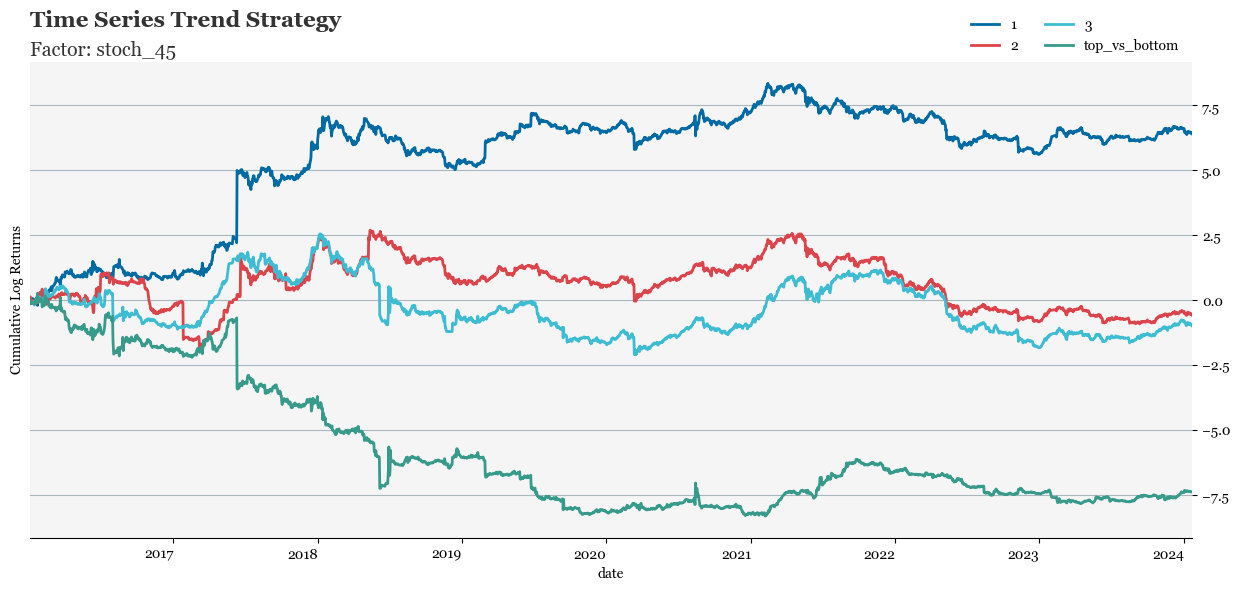

In [169]:
plot_series(trend_ts_quantile_ret.cumsum(),
            title="Time Series Trend Strategy",
            subtitle=f"Factor: {trend_ts_perf_table.iloc[0].name}",
            y_label='Cumulative Log Returns'
           )

In [170]:
trend_ts_quantile_ann_ret = Factor(trend_df.loc['2016-01-01':], ret_df.tr, strategy='ts_ls', factor_bins=3).quantiles(factor=trend_ts_perf_table.iloc[0].name, metric='ann_ret')

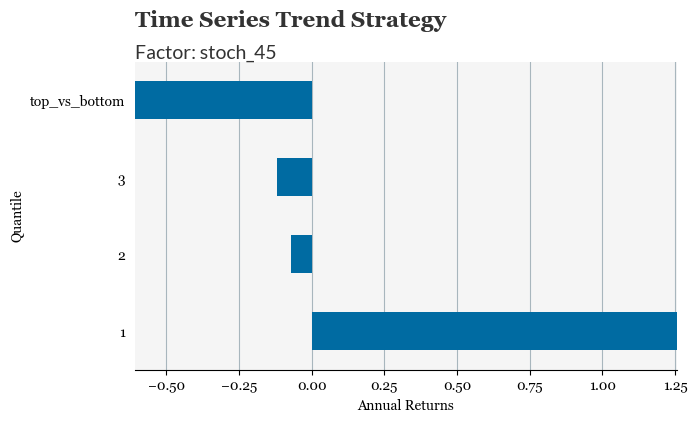

In [171]:
plot_bar(trend_ts_quantile_ann_ret,
         axis='horizontal',
         title="Time Series Trend Strategy",
         subtitle=f"Factor: {trend_ts_perf_table.iloc[0].name}",
         y_label='Quantile',
         x_label='Annual Returns'
        )

In [172]:
trend_ts_quantile_vol = Factor(trend_df.loc['2016-01-01':], ret_df.tr, strategy='ts_ls', factor_bins=3).quantiles(factor=trend_ts_perf_table.iloc[0].name, metric='ann_vol')

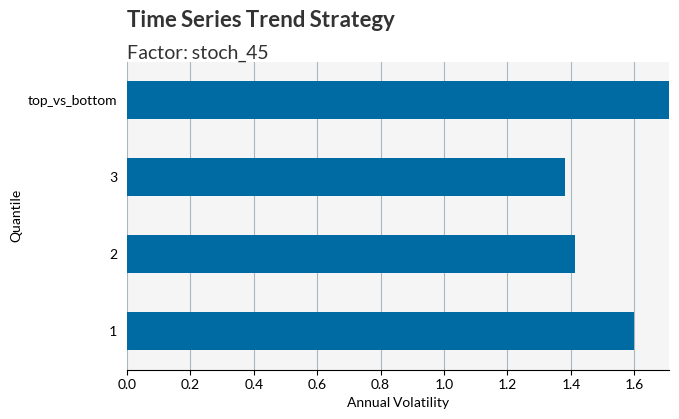

In [173]:
plot_bar(trend_ts_quantile_vol,
         axis='horizontal',
         title="Time Series Trend Strategy",
         subtitle=f"Factor: {trend_ts_perf_table.iloc[0].name}",
         y_label='Quantile',
         x_label='Annual Volatility'
         )

In [174]:
trend_ts_quantile_sr = Factor(trend_df.loc['2016-01-01':], ret_df.tr, strategy='ts_ls', factor_bins=3).quantiles(factor=trend_ts_perf_table.iloc[0].name, metric='sharpe_ratio')

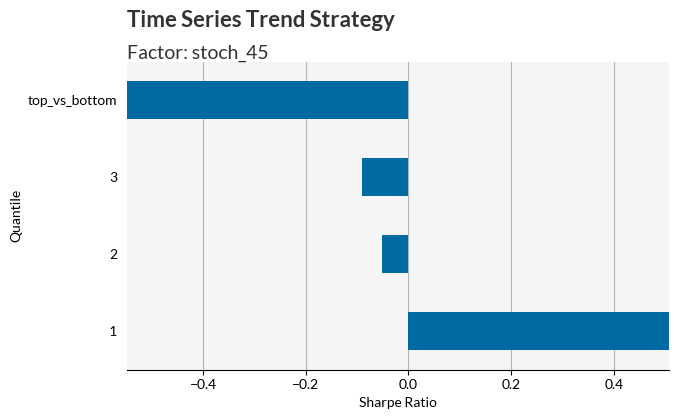

In [175]:
plot_bar(trend_ts_quantile_sr,
         axis='horizontal',
         title="Time Series Trend Strategy",
         subtitle=f"Factor: {trend_ts_perf_table.iloc[0].name}",
         y_label='Quantile',
         x_label='Sharpe Ratio'
        )

### Cross-sectional Strategy

In [176]:
trend_cs_quantile_ret = Factor(trend_df.loc[:], ret_df.tr, strategy='cs_ls', factor_bins=5).quantiles(factor=trend_cs_perf_table.iloc[0].name, metric='ret')

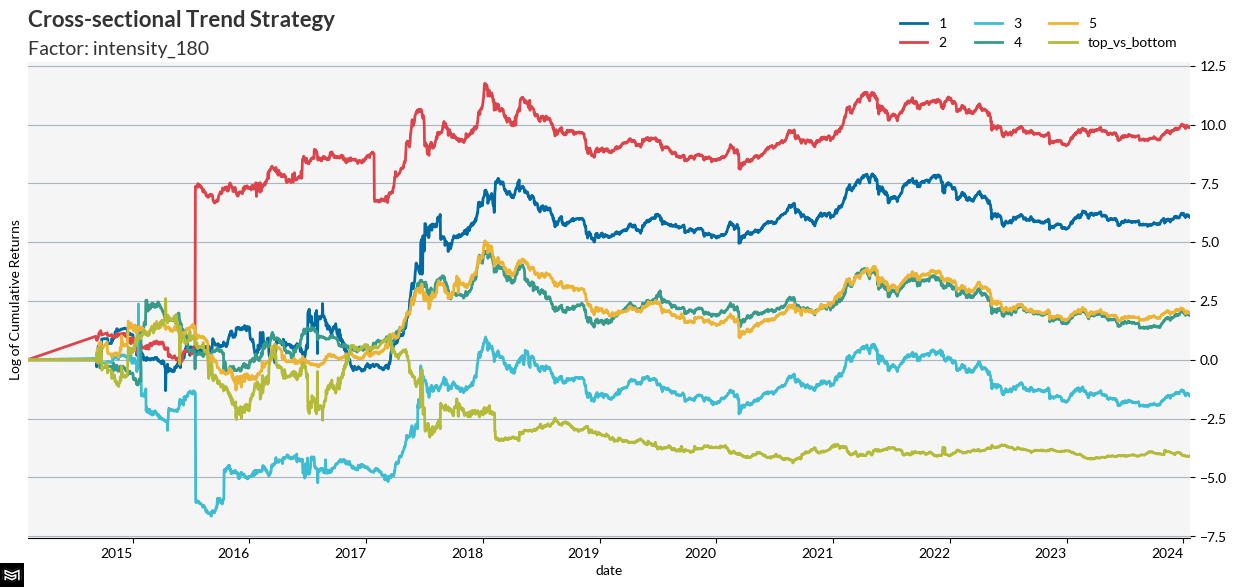

In [177]:
plot_series(trend_cs_quantile_ret.cumsum(),
            title="Cross-sectional Trend Strategy",
            subtitle=f"Factor: {trend_cs_perf_table.iloc[0].name}",
            y_label='Log of Cumulative Returns',
            add_logo=True
           )

In [178]:
trend_cs_quantile_ann_ret = Factor(trend_df.loc['2016-01-01':], ret_df.tr, strategy='cs_ls', factor_bins=5).quantiles(factor=trend_cs_perf_table.iloc[0].name, metric='ann_ret')

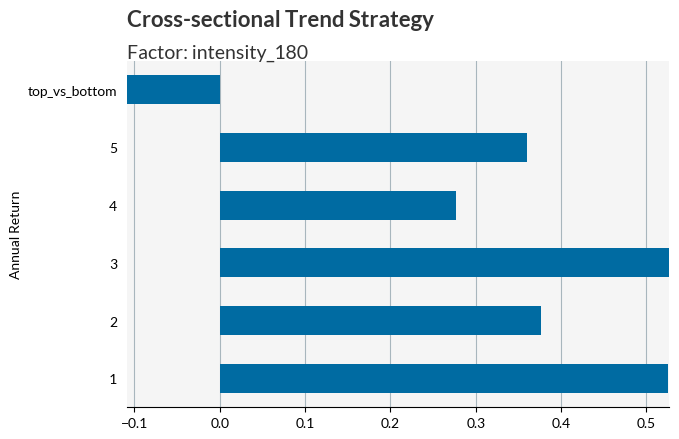

In [179]:
plot_bar(trend_cs_quantile_ann_ret,
         axis='horizontal',
         title="Cross-sectional Trend Strategy",
         subtitle=f"Factor: {trend_cs_perf_table.iloc[0].name}",
         y_label='Annual Return'
           )

In [180]:
trend_cs_quantile_vol = Factor(trend_df.loc['2016-01-01':], ret_df.tr, strategy='cs_ls', factor_bins=5).quantiles(factor=trend_cs_perf_table.iloc[0].name, metric='ann_vol')

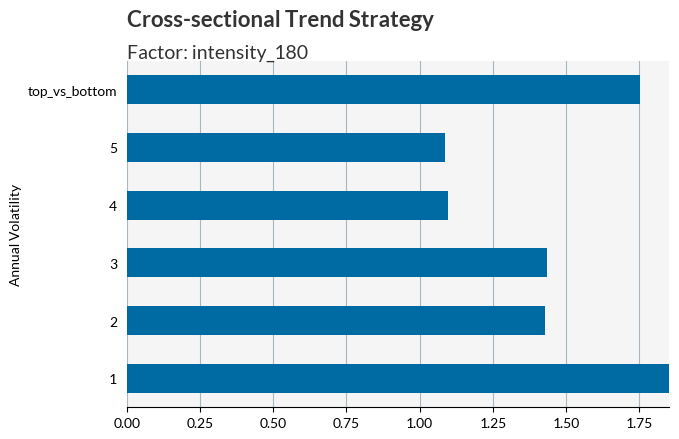

In [181]:
plot_bar(trend_cs_quantile_vol,
         axis='horizontal',
         title="Cross-sectional Trend Strategy",
         subtitle=f"Factor: {trend_cs_perf_table.iloc[0].name}",
         y_label='Annual Volatility'
        )

In [182]:
trend_cs_quantile_sr = Factor(trend_df.loc['2016-01-01':], ret_df.tr, strategy='cs_ls', factor_bins=5).quantiles(factor=trend_cs_perf_table.iloc[0].name, metric='sharpe_ratio')

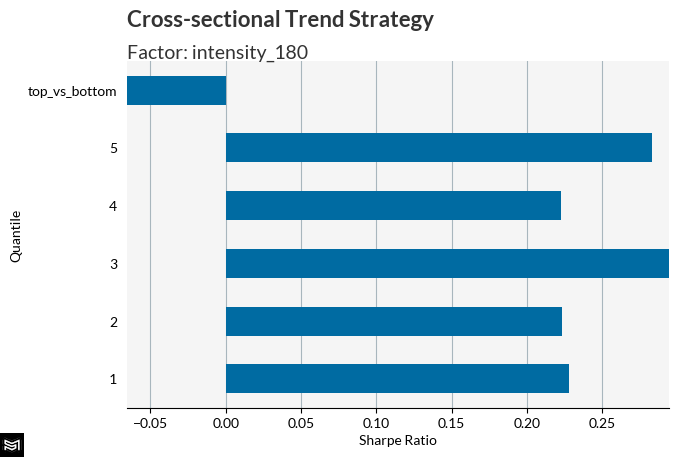

In [183]:
plot_bar(trend_cs_quantile_sr,
         axis='horizontal',
         title="Cross-sectional Trend Strategy",
         subtitle=f"Factor: {trend_cs_perf_table.iloc[0].name}",
         y_label='Quantile',
         x_label='Sharpe Ratio',
         add_logo=True
        )

## Factor Robustness

A robust factor should produce positive returns regardless of changes in construction methodology, inputs and parameter values. One way of assessing the robustness of a factor is to examine how returns change across various implementations, inputs, parameters and sample periods. This can be done as part with the ```factor_param_grid_search``` function:
- The ```feat_args``` parameters allows us to vary all of the attributes that are used to compute all factors with the ```Trend``` class.
- The ```algo_args``` parameters allow us to vary all of the arguments used by the methods which compute specific trend algorithms, e.g. ```price_mom``` or ```time_trend```.

### Factor Parameter Grid Search

The ```Factor``` class has a ```return``` method which computes factor returns. The class attributes and method arguments can be optimized to achieve better performance. We can use the ```strategy_param_grid_search``` to assess the factor strategy's sensitivity to these inputs.

#### Time Series
We explore the parameter space for the best performing time series trend strategy.

In [184]:
metrics_df = factor_param_grid_search(df, ret_df.tr, Trend, 'stochastic', metric='sharpe_ratio',
                                             feat_args={
                                                 'sm_window_type': ['rolling', 'ewm'],
                                                 'lookback': [5, 10, 15, 30, 60, 90, 120, 180, 365],
                                             },
                                             algo_args={'stochastic': ['k', 'd'],
                                                        'signal': [True, False],
                                                        },
                                             factor_args={'strategy': 'ts_ls'},
                                             ret_args={'signal_type': 'signal', 'rebal_freq': 7, 
                                                       't_cost': 0.0025, 'weighting': 'ew'}
                                             )

/Users/nickl/projects/systamental/factorlab/src/factorlab/feature_analysis/param_grid_search.py:383: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  param_matrix = param_df.pivot(*tuple(plot_params))


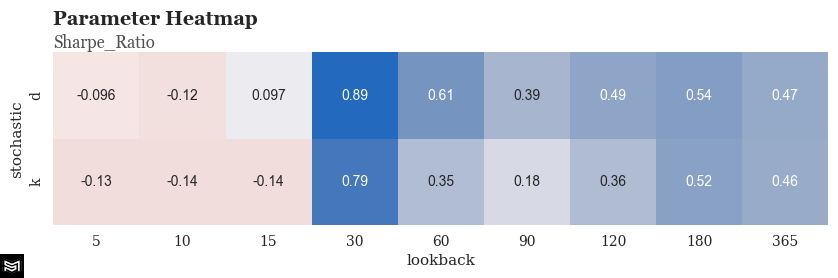

In [185]:
param_matrix = param_heatmap(metrics_df.dropna(), 
                             metric='sharpe_ratio', 
                             fixed_params={'signal': True, 'sm_window_type': 'ewm'}, 
                             plot_params=['stochastic', 'lookback']
                            )

#### Cross Sectional

We explore the parameter space for the best performing cross-sectional trend strategy.

In [186]:
strat_df = strategy_param_grid_search(trend_df[trend_cs_perf_table.iloc[0].name], ret_df.tr, metric='sharpe_ratio',                         
                                
                                factor_args = {
                                    'strategy': ['cs_ls'],
                                     'factor_bins': [3, 5, 7, 10], 
                                },
                         ret_args = {
                             'signal_type': ['signal_quantiles'],
                             'norm_method': ['cdf', 'z-score'],
                             'rebal_freq': [1, 3, 5, 7, 10],
                             'weighting': ['ew', 'vol']
                         })

/Users/nickl/projects/systamental/factorlab/src/factorlab/feature_analysis/param_grid_search.py:383: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  param_matrix = param_df.pivot(*tuple(plot_params))


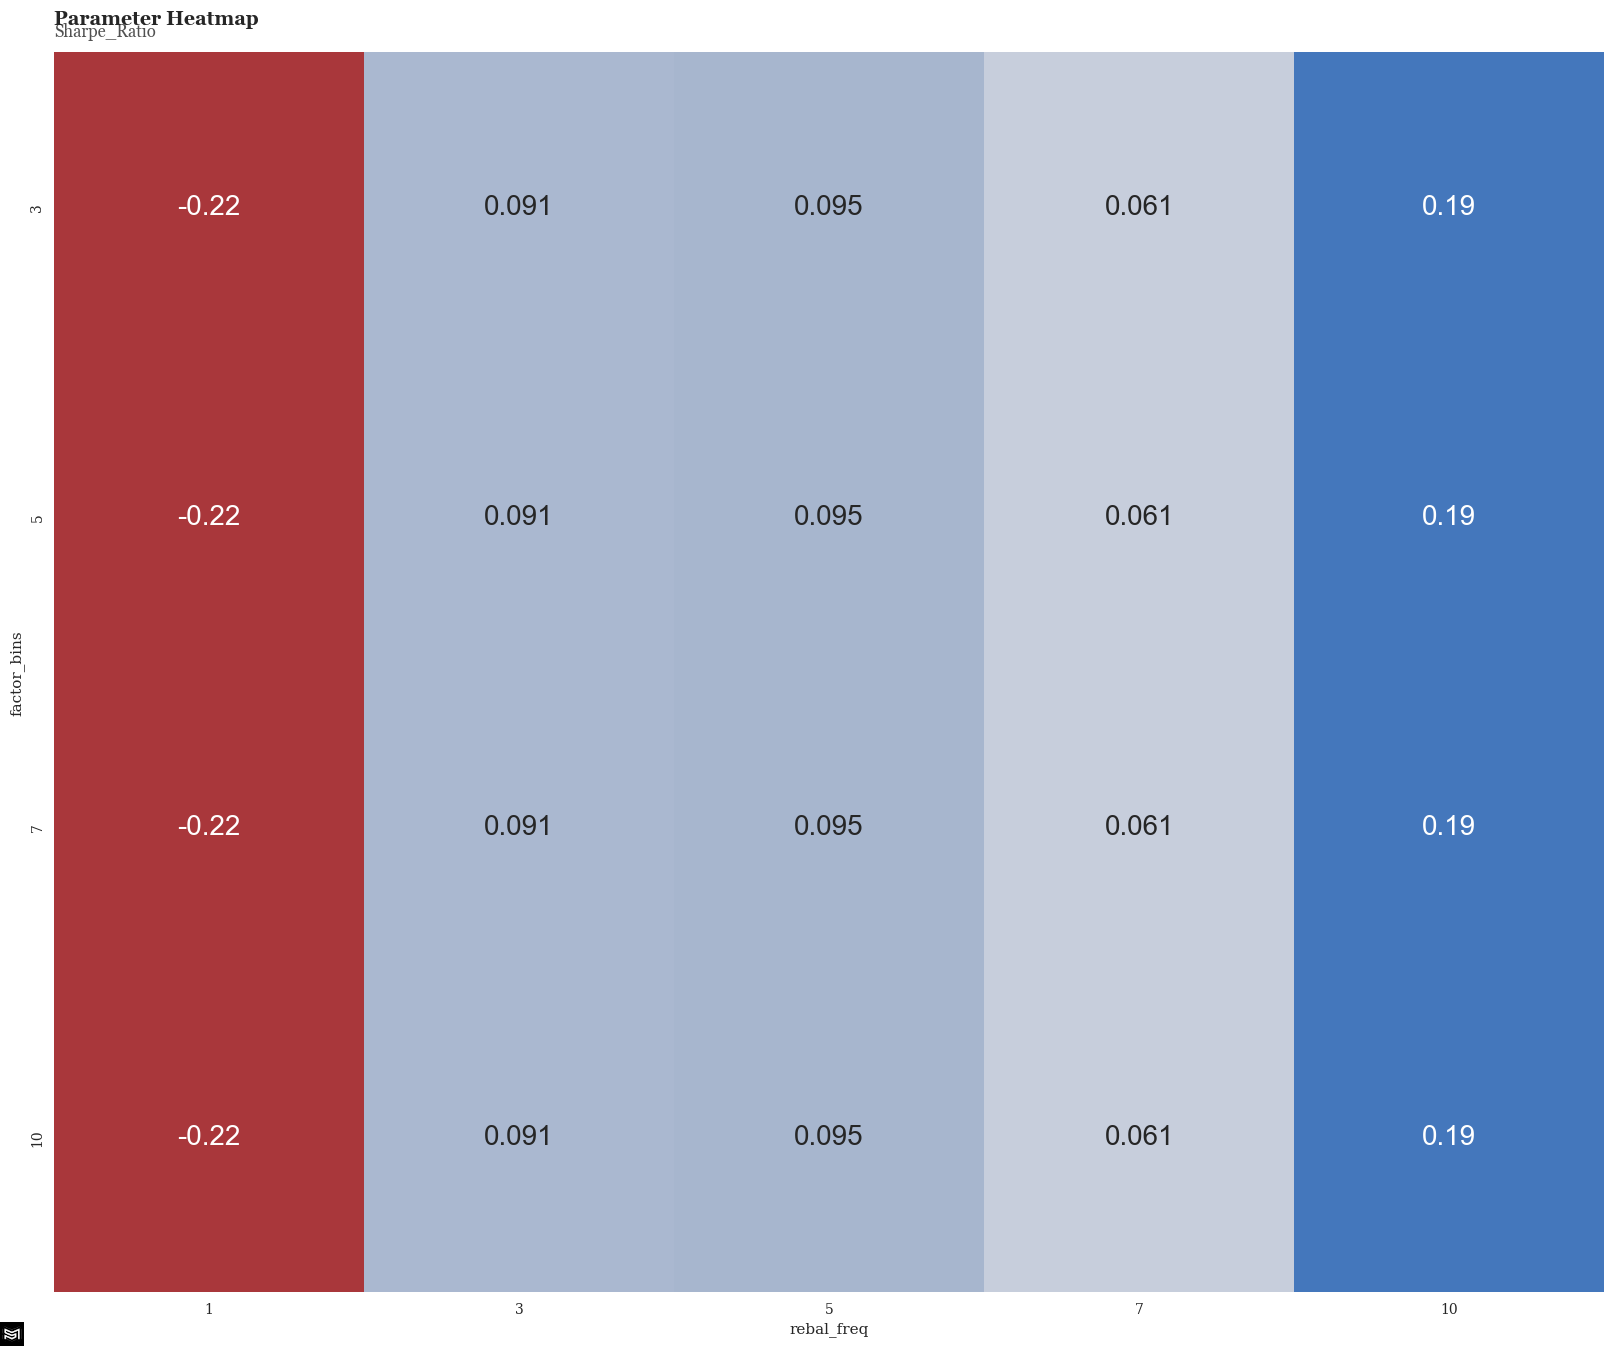

In [187]:
strat_param_matrix = param_heatmap(strat_df.dropna(), 
                             metric='sharpe_ratio', 
                             fixed_params={'strategy': 'cs_ls', 'signal_type': 'signal_quantiles', 'norm_method': 'cdf', 'weighting':'ew'}, 
                             plot_params=['factor_bins', 'rebal_freq']
                                  )

## Trend Dashboard

In [188]:
trend_signals_bar = trend_df.stoch_30.unstack().iloc[-1].sort_values().dropna()

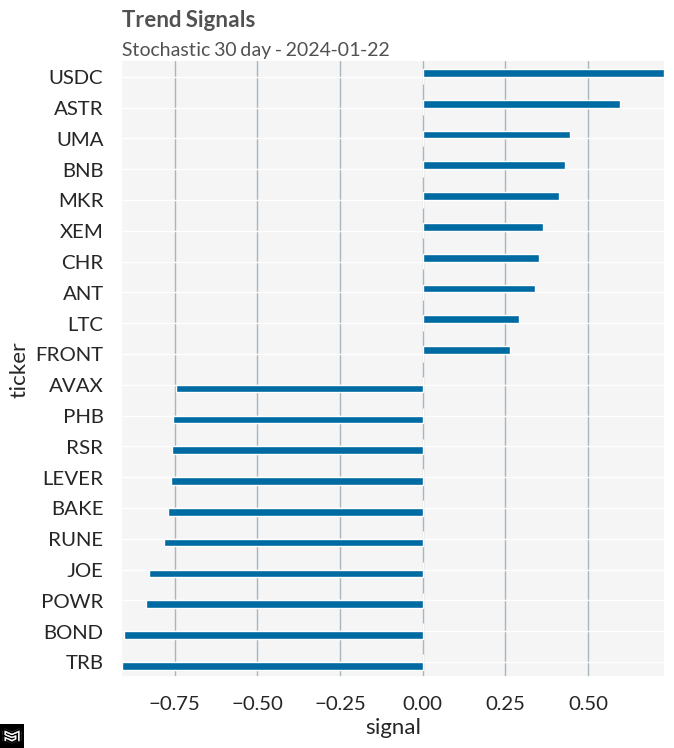

In [189]:
plot_bar(pd.concat([trend_signals_bar[:10], trend_signals_bar[-10:]], axis=1), 
         title="Trend Signals",
         subtitle=f"Stochastic 30 day - {trend_df.iloc[-1].name[0].date()}",
         axis='horizontal', 
         y_label='ticker', 
         x_label='signal', 
         add_logo=True,
        )